In [1]:
import time
import sys
# import os
# path_project = "\\".join(os.getcwd().split("\\")[:-1])
# # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, path_project)

from hardware.hardwaremanager import HardwareManager
from hardware import config as hcf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
hw = HardwareManager()
hw.add_default_hardware()

from measurement.task_base import JobManager

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
# from measurement.timesweep import TimeSweep
# task_ts = TimeSweep()
# from measurement.timesweep import HahnEcho
# task_ts = HahnEcho()
from measurement.sensingprotocol import NuclearQuasiStaticTrack
task = NuclearQuasiStaticTrack()

In [4]:
paraset = dict(
            rate_refresh=15.0,
            # --------------------
            laser_current=80.0,  # percentage
            mw_freq=392.8546 + 4.0e-3,  # GHz
            mw_powervolt=5.0,  # voltage 0.0 to 5.0
            mw_phasevolt=0.0,  # voltage 0.0 to 5.0
            rf_set=False,  # set the RF manually before running the measurement
            # rf_a_amp=0.5,  # amplitude for rf A
            # rf_b_amp=0.5,  # amplitude for rf B
            # rf_a_freq=600.8,  # MHz
            # rf_b_freq=600.8,  # MHz
            # rf_a_phase=0.0,  # phase for rf A
            # rf_b_phase=0.0,  # phase for rf B
            amp_input=200.0,  # input amplitude for digitizer
            # -------------------
            n_track=300,  # number of tracks
            # -------------------
            t_prep_laser=10.0,  # laser time in the preparation phase in a track
            t_prep_isc=250.0,  # wait time for ISC in the preparation phase in a track
            n_prep_lpul=40,  # number of laser pulses in the preparation phase in a track
            # -------------------
            t_prob_init_wait=300.0,
            t_prob_mw_a_pio2=58.0,
            t_prob_phacc=0.0,
            t_prob_read_wait=300.0,
            t_prob_laser=1000.0,
            n_dbloc_fwd=12,  # number of a probe
            n_dbloc_bwd=12,  # number of b probe
            # -------------------
            t_rf_pio2=16666,
            t_prlo=12000,  # pre-lock time
            t_lock_fwd=21000,
            t_lock_bwd=21000,
            # --------------------
            t_relax=0.2,  # seconds
            # -------------------
            emulate=True,
            emulate_acfreq=3113.0,
            emulate_volt=1.0,
        )
task.set_paraset(**paraset)

In [5]:
time_mea =36.0  # seconds
task.set_stoptime(time_mea)
JobManager().start()
JobManager().submit(task)
# 
# task.start()
time.sleep(time_mea)
JobManager().remove(task)
JobManager().stop()

Please set the RF manually before running the measurement


RF Duty Cycle: 10%
Setting Analog channel 0
Skipping unpicklable attribute: _thread
Card stopped


In [6]:
dataset = task.get_dataset()

In [7]:
# hw.pg.plotSeq()

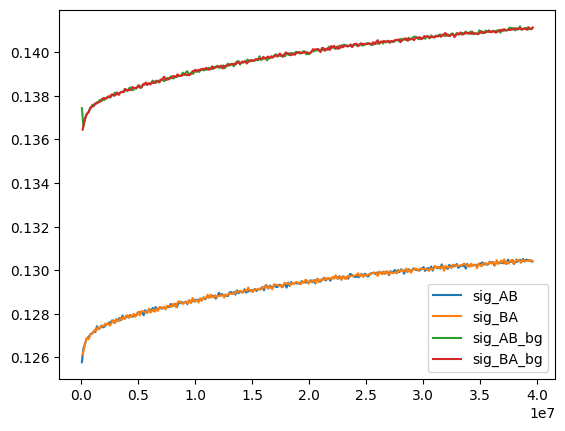

In [8]:
# import matplotlib.pyplot as plt
tau_AB = dataset["tau_AB"]
tau_BA = dataset["tau_BA"]
sig_AB = dataset["sig_AB"]
sig_AB_bg = dataset["sig_AB_bg"]
sig_BA = dataset["sig_BA"]
sig_BA_bg = dataset["sig_BA_bg"]
plt.plot(tau_AB, dataset["sig_AB"], label="sig_AB")
plt.plot(tau_BA, dataset["sig_BA"], label="sig_BA")
plt.plot(tau_AB, dataset["sig_AB_bg"], label="sig_AB_bg")
plt.plot(tau_BA, dataset["sig_BA_bg"], label="sig_BA_bg")
plt.legend()
plt.show()


In [9]:
# --- Define a helper function for FFT calculation ---
def calculate_fft(signal_avg, tau_array):
    N = len(signal_avg)
    try:
        T = tau_array[1] - tau_array[0]  # Sample spacing
    except IndexError:
        print("Warning: tau_array might not have enough points to determine sample spacing. Assuming T=1.")
        T = 1.0  # Default to 1 if not enough points

    # Remove DC component (mean) before FFT
    yf = np.fft.fft(signal_avg - np.mean(signal_avg))
    xf = np.fft.fftfreq(N, T)[:N//2] * 1e9

    # Amplitude normalization
    amplitude = 2.0/N * np.abs(yf[0:N//2])
    return xf, amplitude

# Calculate FFT for both signals
xf_AB, amp_AB = calculate_fft(sig_AB, dataset["tau_AB"])
xf_BA, amp_BA = calculate_fft(sig_BA, dataset["tau_BA"])
xf_AB, amp_AB_bg = calculate_fft(sig_AB_bg, dataset["tau_AB"])
xf_BA, amp_BA_bg = calculate_fft(sig_BA_bg, dataset["tau_BA"])
xf_AB, amp_AB_df = calculate_fft(sig_AB-sig_AB_bg, dataset["tau_AB"])
xf_BA, amp_BA_df = calculate_fft(sig_BA-sig_BA_bg, dataset["tau_BA"])


# --- Plotting with Plotly ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots for time domain and frequency domain
fig = make_subplots(rows=1, cols=1,
                    subplot_titles=('Averaged Signals (Time Domain)', 'FFT of Averaged Signals (Frequency Domain)'))



# Add frequency domain plots
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB, mode='lines', name='FFT of sig_AB'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA, mode='lines', name='FFT of sig_BA'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB_bg, mode='lines', name='FFT of bg sig_AB'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA_bg, mode='lines', name='FFT of bg sig_BA'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_AB-amp_AB_bg), mode='lines', name='FFT of sig_AB_df'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=np.abs(amp_BA-amp_BA_bg), mode='lines', name='FFT of sig_BA_df'),
              row=1, col=1)


# Update layout for frequency domain plot
fig.update_xaxes(title_text='Frequency (Hz)', row=1, col=1) # Changed to MHz

fig.update_yaxes(title_text='Amplitude', row=1, col=1)

# Update overall layout
fig.update_layout(width=800, showlegend=True, hovermode="x unified")
fig.show()

In [10]:
from analysis.spectroscopy import filter_rising_background, apply_sigmoid_window, apply_zero_padding, calculate_fft, auto_phase

tau_AB_origin = dataset["tau_AB"]
tau_BA_origin = dataset["tau_BA"]
sig_AB_origin = dataset["sig_AB"]
sig_BA_origin = dataset["sig_BA"]
n_avg = 1
amp_df = 0.0
amp_df_raw = 0.0
amp_df_phased = 0.0
amp_df_phased_anti= 0.0
for ii in range(n_avg):
    tau_AB = tau_AB_origin[ii::n_avg]
    tau_BA = tau_BA_origin[ii::n_avg]
    sig_AB = sig_AB_origin[ii::n_avg]
    sig_BA = sig_BA_origin[ii::n_avg]
    # filter out the decay dynamics
    sig_AB_filtered, sig_AB_subtrate = filter_rising_background(tau_AB, sig_AB)
    sig_BA_filtered, sig_BA_subtrate = filter_rising_background(tau_BA, sig_BA)

    # perform apodization and zero filling
    decay_apod = 0.5*1E9/(tau_AB[-1]-tau_AB[0])
    factor_zp = 16

    sig_AB_ac = sig_AB_filtered
    sig_AB_zp_ap = apply_sigmoid_window(tau_AB, sig_AB_ac)
    tau_AB_zp_ap, sig_AB_zp_ap = apply_zero_padding(tau_AB, sig_AB_zp_ap, factor_zp)

    sig_BA_ac = sig_BA_filtered
    sig_BA_zp_ap = apply_sigmoid_window(tau_BA, sig_BA_ac)
    tau_BA_zp_ap, sig_BA_zp_ap = apply_zero_padding(tau_BA, sig_BA_zp_ap, factor_zp)


    # Calculate FFT for both signals
    xf_AB, amp_AB = calculate_fft(sig_AB_zp_ap, tau_AB_zp_ap, DCfilter=False)
    xf_BA, amp_BA = calculate_fft(sig_BA_zp_ap, tau_BA_zp_ap, DCfilter=False)

    # amp_AB_df = amp_AB
    # amp_BA_df = amp_BA

    # amp_df = np.abs((amp_AB_df+amp_BA_df)/2.0)
    amp_df += np.abs(amp_AB) + np.abs(amp_BA)
    # amp_df += amp_AB + amp_BA
    # amp_df_norm = amp_df/np.max(amp_df[len(amp_df)//2:])

    xf_AB_raw, amp_AB_raw = calculate_fft(sig_AB, tau_AB, DCfilter=True)
    xf_BA_raw, amp_BA_raw = calculate_fft(sig_BA, tau_BA, DCfilter=True)

    amp_AB_df_raw = amp_AB_raw
    amp_BA_df_raw = amp_BA_raw
    amp_df_raw += np.abs(amp_AB_df_raw)+np.abs(amp_BA_df_raw)/2.0
    # amp_df_raw += np.abs((amp_AB_df_raw+amp_BA_df_raw)/2.0)
    # amp_df_raw += amp_AB_raw+amp_BA_raw
    # amp_df_raw_norm = amp_df_raw/np.max(amp_df_raw[len(amp_df_raw)//2:])

    # Phase correction to each spectrum
    amp_AB_modi = amp_AB
    amp_BA_modi = amp_BA
    fwhm_factor = 0.1
    p1_limit = 0.0
    amp_AB_df_phased, p0_AB, p1_AB = auto_phase(amp_AB_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_AB_df_phased_neg, p0_AB, p1_AB = auto_phase(-amp_AB_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_BA_df_phased, p0_BA, p1_BA = auto_phase(amp_BA_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_BA_df_phased_neg, p0_BA, p1_BA = auto_phase(-amp_BA_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_df_phased += amp_AB_df_phased+amp_BA_df_phased
    amp_df_phased_anti += amp_AB_df_phased+amp_BA_df_phased+amp_AB_df_phased_neg+amp_BA_df_phased_neg

amp_df = np.abs(amp_df)
amp_df_norm = amp_df/np.max(amp_df[int(len(amp_df)*0.2):])
amp_df_raw = np.abs(amp_df_raw)
amp_df_raw_norm = amp_df_raw/np.max(amp_df_raw[int(len(amp_df_raw)*0.2):])
# amp_df_raw_norm[:int(len(amp_df_raw)*0.2)]=0

amp_df_phased = amp_df_phased/np.max(amp_df_phased.real)
amp_df_phased_anti = amp_df_phased_anti/np.max(amp_df_phased_anti.real)
a = 0.4
b = 0.6
amp_df_combined = (a*amp_df_norm+b*amp_df_phased.real)/(a+b)
amp_df_combined_anti = (a*amp_df_norm+b*amp_df_phased_anti.real)/(a+b)


# --- Plotting with Plotly ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots for time domain and frequency domain
fig = make_subplots(rows=1, cols=1,
                    subplot_titles=('Averaged Signals (Time Domain)', 'FFT of Averaged Signals (Frequency Domain)'))



# Add frequency domain plots

fig.add_trace(go.Scatter(x=xf_AB_raw, y=amp_df_raw_norm, mode='lines', name='raw'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=amp_df_norm, mode='lines', name='filtered'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_phased.real), mode='lines', name='filtered phased'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_phased_anti.real), mode='lines', name='filter phased anti'),
              row=1, col=1)
# fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_combined), mode='lines', name='combine filter phased'),
#               row=1, col=1)
# fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_combined_anti), mode='lines', name='combine filter phased anti'),
#               row=1, col=1)

# Update layout for frequency domain plot
fig.update_xaxes(title_text='Frequency (Hz)', row=1, col=1) # Changed to MHz

fig.update_yaxes(title_text='Amplitude', row=1, col=1, range=[0, 1.1])


# Update overall layout
fig.update_layout(width=800, showlegend=True, hovermode="x unified")
fig.show()

Fit successful. Parameters:
  A1=0.0021, tau1=7.25e+05, beta1=0.561
  A2=0.0022, tau2=2.00e+07, beta2=1.198
  A3=0.0025, tau3=1.00e+08, beta3=1.038
  C=0.1256
Fit successful. Parameters:
  A1=0.0015, tau1=3.89e+05, beta1=0.777
  A2=0.0030, tau2=1.86e+07, beta2=0.894
  A3=0.0025, tau3=1.03e+08, beta3=1.007
  C=0.1256
Applying sigmoid window for truncated FID...
Applying zero padding with factor x16...
Applying sigmoid window for truncated FID...
Applying zero padding with factor x16...
Starting global grid search...
Global search complete. Best guess: p0=180.50, p1=0.00
Starting local optimization...
Optimization complete. Best guess: p0=151.55, p1=0.00
Starting global grid search...
Global search complete. Best guess: p0=0.50, p1=0.00
Starting local optimization...
Optimization complete. Best guess: p0=-28.45, p1=0.00
Starting global grid search...
Global search complete. Best guess: p0=0.50, p1=0.00
Starting local optimization...
Optimization complete. Best guess: p0=4.20, p1=0.00
Sta

In [11]:
from analysis.spectroscopy import calculate_snr
fwhm_factor = 0.5
snr_raw = calculate_snr(amp_df_raw_norm, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_abssum = calculate_snr(amp_df_norm, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_phased = calculate_snr(amp_df_phased, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_phased_anti = calculate_snr(amp_df_phased_anti, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_combin = calculate_snr(amp_df_combined, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_combin_anti = calculate_snr(amp_df_combined_anti, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)

print(f"SNR for signal raw:{snr_raw}")
print(f"SNR for signal abssum:{snr_abssum}")
print(f"SNR for signal phased:{snr_phased}")
print(f"SNR for signal phased_anti:{snr_phased_anti}")
print(f"SNR for signal combined:{snr_combin}")
print(f"SNR for signal combined anti:{snr_combin_anti}")

SNR for signal raw:0.0
SNR for signal abssum:7.098237875588765
SNR for signal phased:9.597277538496543
SNR for signal phased_anti:9.597277832088173
SNR for signal combined:11.85160355723882
SNR for signal combined anti:11.851603694068611
